In [ ]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout, UpSampling2D
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive"

/content/drive/MyDrive


In [ ]:
!ls

'Colab Notebooks'	'Mohamed_Talayea_resume (1).pdf'   sandstone.zip
'Concentrix Task.docx'	 Mohamed_Talayea_resume.pdf
'Concentrix Task.gdoc'	 sandstone


In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/sandstone.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [ ]:
image = os.listdir("/content/sandstone/images")
image_dir  = "/content/sandstone/images"
mask_dir = "/content/sandstone/masks"

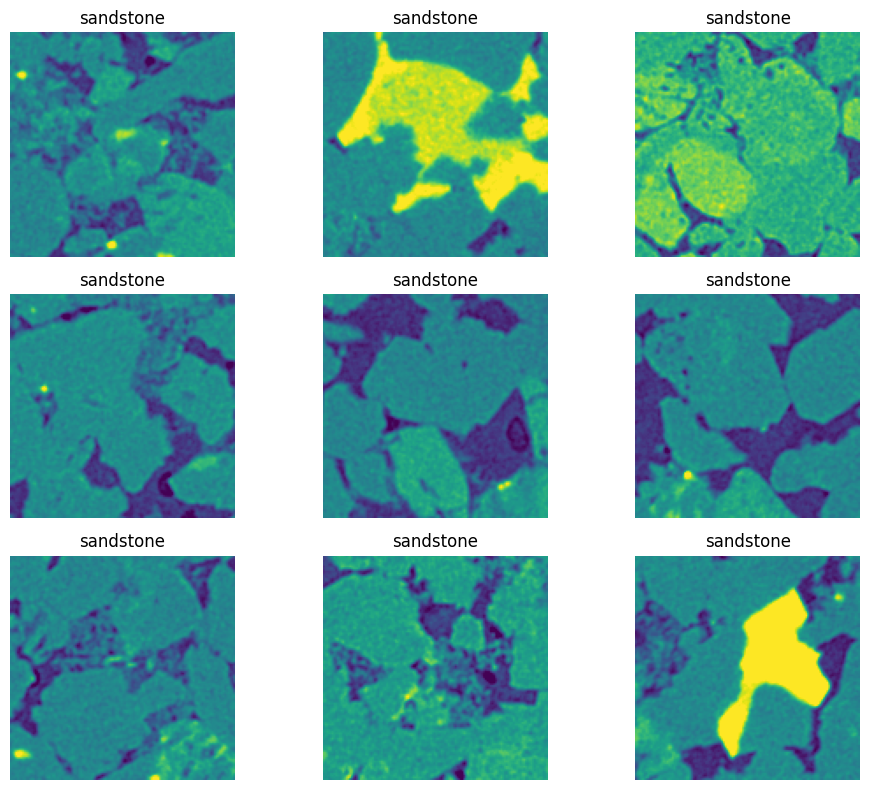

In [ ]:
plt.figure(figsize=(10,8))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = Image.open(os.path.join(image_dir, image[i]))
    plt.imshow(img)
    plt.axis("off")
    plt.title("sandstone")
plt.tight_layout()

In [ ]:
print("Number of images:", len(image))
print("Sample files:", image[:5])  # Display first 5 files

Number of images: 1600
Sample files: ['image_523.tif', 'image_309.tif', 'image_298.tif', 'image_450.tif', 'image_440.tif']


In [ ]:
# Paths to your input images and masks
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

def one_hot_encode_mask(mask, num_classes=4):
    # Define the pixel values representing each class in the original mask
    class_values = [0, 1, 2, 3]  # Replace with actual values in your masks
    one_hot_mask = np.zeros((mask.shape[0], mask.shape[1], num_classes), dtype=np.uint8)

    # Loop over each class and set the corresponding channel
    for i, value in enumerate(class_values):
        one_hot_mask[:, :, i] = np.where(mask == value, 1, 0)

    return one_hot_mask

def load_data(image_paths, mask_paths):
    images = []
    masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load image and mask with target size and color mode
        img = load_img(img_path, target_size=(128, 128), color_mode='grayscale')  # Adjust size as needed
        mask = load_img(mask_path, target_size=(128, 128), color_mode='grayscale')

        # Convert to numpy arrays
        img = img_to_array(img) / 255.0  # Normalize image to [0,1]
        mask = img_to_array(mask).astype(np.uint8)[:, :, 0]  # Keep mask as single channel integers

        # One-hot encode the mask
        mask = one_hot_encode_mask(mask)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [ ]:
# Load data
images, masks = load_data(image_paths, mask_paths)
print("Images shape:", images.shape)  # Should be (num_images, 128, 128, 1) if grayscale
print("Masks shape:", masks.shape)    # Should be (num_images, 128, 128, 4)
print("Unique classes in masks:", np.unique(masks))

Images shape: (1600, 128, 128, 1)
Masks shape: (1600, 128, 128, 4)
Unique classes in masks: [0 1]


In [ ]:
masks

array([[[[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         ...,
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         ...,
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         ...,
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]],

        ...,

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         ...,
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         ...,
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         ...,
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]]],


       [[[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0

In [ ]:
# Load the data
X_train, Y_train = load_data(image_paths, mask_paths)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [ ]:
def unet(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)

    # Contracting Path (Encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expanding Path (Decoder)
    u6 = UpSampling2D(2)(c5)
    u6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    u6 = layers.concatenate([u6, c4], axis=3)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D(2)(c6)
    u7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    u7 = layers.concatenate([u7, c3], axis=3)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D(2)(c7)
    u8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    u8 = layers.concatenate([u8, c2], axis=3)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D(2)(c8)
    u9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output Layer
    output = layers.Conv2D(4, (1, 1), activation='sigmoid')(c9)  # For binary segmentation

    model = models.Model(inputs=inputs, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = unet(input_size=(128, 128, 1))  # Example input size for grayscale image (128x128)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 128, 128, 64)   │            640 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 64, 64, 64)     │              0 │ conv2d_39[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 32, 32, 128)    │              0 │ conv2d_41[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 16, 16, 256)    │              0 │ conv2d_43[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 8, 8, 512)      │              0 │ conv2d_45[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_46[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 16, 1024)   │              0 │ conv2d_47[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)   

 Total params: 34,512,388 (131.65 MB)

 Trainable params: 34,512,388 (131.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = unet(input_size=(128, 128, 1))  # Replace with your U-Net model for segmentation

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=32,
    epochs=20
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 518ms/step - accuracy: 0.6974 - loss: 2.8250 - val_accuracy: 0.7529 - val_loss: 0.2524
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 470ms/step - accuracy: 0.7919 - loss: 0.2318 - val_accuracy: 0.8818 - val_loss: 0.1500
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 476ms/step - accuracy: 0.8848 - loss: 0.1473 - val_accuracy: 0.9004 - val_loss: 0.1275
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 482ms/step - accuracy: 0.9064 - loss: 0.1257 - val_accuracy: 0.9121 - val_loss: 0.1189
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 488ms/step - accuracy: 0.9151 - loss: 0.1078 - val_accuracy: 0.9382 - val_loss: 0.0556
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 493ms/step - accuracy: 0.9267 - loss: 0.0613 - val_accuracy: 0.9407 - val_loss: 0.0535
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 493ms/step - accuracy: 0.9317 - loss: 0.0498 - val_accuracy: 0.9414 - val_loss: 0.0488
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 498ms/step - accuracy: 0.9407 - loss: 0.0402 - val_accu

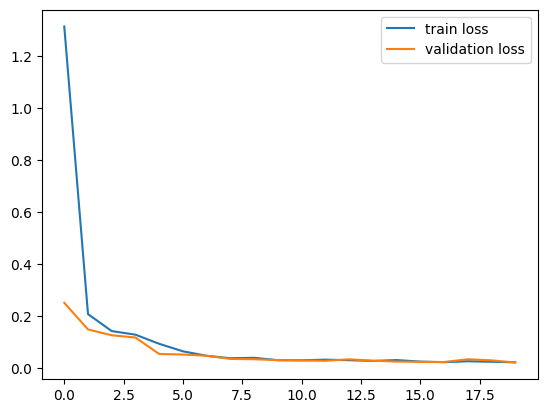

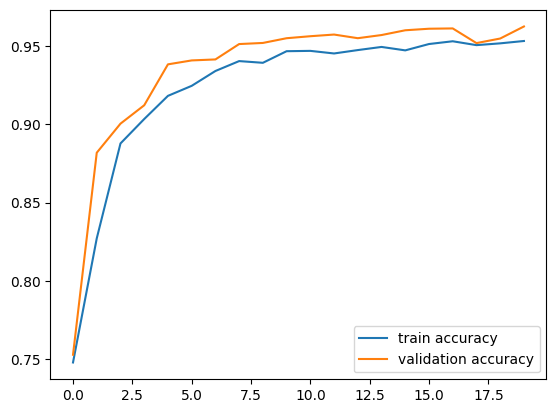

In [ ]:
 h = history

# plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# plot the accuracy value
plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


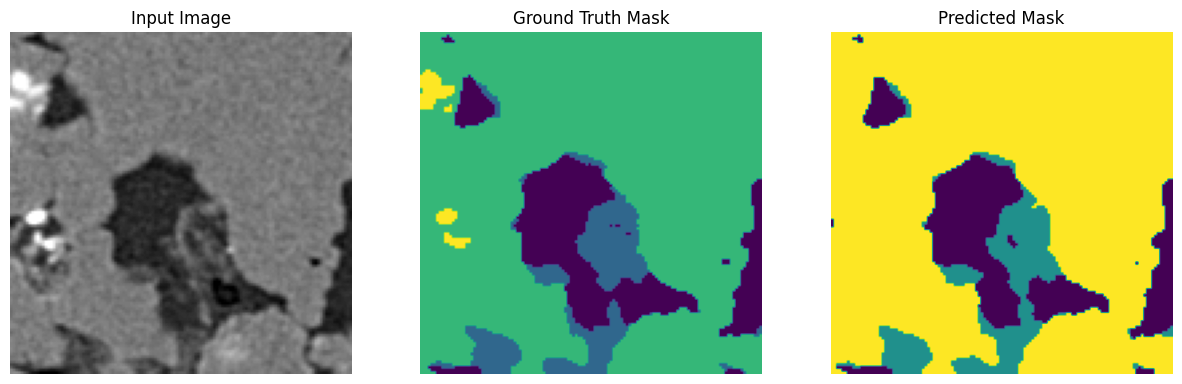

In [ ]:
# Load and preprocess the image for prediction
image_path = '/content/sandstone/images/image_1.tif'  # Replace with your image path
mask_path = '/content/sandstone/masks/image_1.tif'    # Replace with your mask path
target_size = (128, 128)  # Adjust based on your model's input size

# Load the image and preprocess it
img = load_img(image_path, target_size=target_size, color_mode='grayscale')
img = img_to_array(img) / 255.0  # Normalize the image to [0, 1]
img = np.expand_dims(img, axis=0)  # Add batch dimension (1, 128, 128, 1)

# Load the ground truth mask and preprocess it
mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')
mask = img_to_array(mask)[:, :, 0]  # Convert to numpy array and flatten to 2D if grayscale

# Load your trained model (if not already loaded)
# model = load_model('path_to_your_model.h5')  # Uncomment and replace with the actual path if needed

# Make a prediction
prediction = model.predict(img)
predicted_mask = np.argmax(prediction[0], axis=-1)  # Get the predicted class for each pixel

# Plot the input image, ground truth mask, and predicted mask
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Show the input image
axs[0].imshow(img[0, :, :, 0], cmap='gray')  # Assumes single-channel grayscale
axs[0].set_title("Input Image")
axs[0].axis('off')

# Show the ground truth mask
axs[1].imshow(mask, cmap='viridis')  # Use a color map to differentiate classes
axs[1].set_title("Ground Truth Mask")
axs[1].axis('off')

# Show the predicted mask
axs[2].imshow(predicted_mask, cmap='viridis')  # Use the same color map for consistency
axs[2].set_title("Predicted Mask")
axs[2].axis('off')

plt.show()